In [1]:
import pandas as pd
import numpy as np

import sys

import configparser

import geopandas as gpd
import shapely


from fluxdataqaqc import Data, QaQc, Plot

from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [2]:
sys.path.append("//")
#sys.path.append("../../Micromet")
import micromet
from micromet import AmerifluxDataProcessor
%matplotlib inline

In [3]:
from pyproj import Transformer
EPSG = 5070
# load initial flux data
station = 'US-UTW'
config_path = f'../../station_config/{station}.ini'
config = configparser.ConfigParser()
config.read(config_path)

d = Data(config_path)
d.df.index.freq = '30min'
df = d.df.rename(columns=d.inv_map)
q = QaQc(d, daily_frac=3/4, max_interp_hours=4, max_interp_hours_night=6)

# make copies of daily results of different correction options
q.correct_data(meth='ebr', et_gap_fill=True)
ebr_gapfilled = q.df


latitude = config['METADATA']['station_latitude']
longitude = config['METADATA']['station_longitude']

# Define the transformer from WGS84 to NAD83 Conus Albers
transformer = Transformer.from_crs("EPSG:4326", f"EPSG:{EPSG}", always_xy=True)

# Perform the transformation
station_x, station_y = transformer.transform(longitude, latitude)

print(f"Projected Coordinates in NAD83 Conus Albers (EPSG:5070): X={station_x}, Y={station_y}")

Calculating mean for var: THETA from columns: ['SWC_1_1_1', 'SWC_2_1_1']
Converting vpd from hpa to kpa
Calculating vapor pressure from vapor pressure deficit and air temperature
Calculating dew point temperature from vapor pressure

The input data temporal frequency appears to be less than daily.


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis12\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Data is being resampled to daily temporal frequency.
Linearly interpolating gaps in energy balance components up to 6 hours when Rn < 0 and up to 4 hours when Rn >= 0.
Filtering days with less then 75.0% or 36/48 sub-daily measurements
gridMET reference ET already downloaded for station at:
C:\Users\paulinkenbrandt\Documents\GitHub\MicroMet\Notebooks\Footprints\..\..\station_config\gridMET_data\US-UTW_39.4417N_-110.7250W.csv
not redownloading.
Gap filling ET_corr with filtered ETrF x ETr (gridMET)
Projected Coordinates in NAD83 Conus Albers (EPSG:5070): X=-1251001.2763440341, Y=1921956.3381891234


In [5]:
foot_xy = {}
data = pd.read_csv(config['METADATA']['climate_file_path'],
                   skiprows=int(config['METADATA']['skiprows']))
#df = pd.read_csv("../../station_data/US-CdM_HH_202306141100_202410081700.csv")
for col in data.columns:
    if "fetch" in col.lower():
        data = micromet.polar_to_cartesian_dataframe(data, wd_column='WD',dist_column=col)
        data[f'X_{col}'] = data[f'X_{col}'] + station_x
        data[f'Y_{col}'] = data[f'Y_{col}'] + station_y

        foot_xy[col] = micromet.aggregate_to_daily_centroid(data,'datetime_start',f'X_{col}',f'Y_{col}')

daily_pnts = foot_xy['FETCH_55']
daily_pnts['geometry'] = gpd.points_from_xy(daily_pnts['X_FETCH_55'],
                                      daily_pnts['Y_FETCH_55'])
daily_pnts['date'] = pd.to_datetime(daily_pnts['Date'])
daily_pnts.drop(columns='Date', inplace=True)
daily_pnts.set_index('date', inplace=True)
daily_pnts = pd.concat([ebr_gapfilled, daily_pnts], axis=1)
daily_pnts_geo = gpd.GeoDataFrame(daily_pnts, geometry=daily_pnts.geometry)

In [10]:
daily_pnts.dropna(subset=['X_FETCH_55', 'ET'], inplace=True)
daily_pnts

,vp,T_SONIC,VPD,input_H,RH_1_1_1,NETRAD,SWC_2_1_1,LW_IN,SW_OUT,WD,...,gridMET_ETo,gridMET_prcp,ETrF,ETrF_filtered,ET_fill,ET_gap,ET_fill_val,X_FETCH_55,Y_FETCH_55,geometry
date,,,,,,,,,,,,,,,,,,,,,
2021-05-21,0.499443,16.244161,1.370809,-47.461760,25.622743,124.574898,NaN,328.338150,48.109834,164.452621,...,6.0,0.0,0.653689,0.694108,6.316379,False,NaN,-1.250986e+06,1.921881e+06,POINT (-1250985.916 1921880.915)
2021-05-22,0.270123,11.423597,1.145534,-7.109466,18.241680,112.493020,NaN,302.924508,42.187538,178.255433,...,5.8,0.0,0.476219,0.681883,5.796005,False,NaN,-1.250995e+06,1.921891e+06,POINT (-1250995.479 1921891.266)
2021-05-23,0.384735,10.083562,0.874428,13.991777,30.372326,190.005219,NaN,290.308333,59.294365,214.676067,...,4.7,0.0,0.865302,0.698501,4.540258,False,NaN,-1.251029e+06,1.921913e+06,POINT (-1251028.731 1921912.625)
2021-05-24,0.439603,11.356567,0.987158,39.250973,34.986726,246.568210,22.707600,280.899615,73.641898,233.673751,...,5.6,0.0,0.781220,0.698501,5.308610,False,NaN,-1.251054e+06,1.921974e+06,POINT (-1251053.601 1921974.001)
2021-05-25,0.381739,14.597245,1.435553,19.460317,24.064791,230.981100,NaN,307.123498,60.800114,166.180429,...,6.6,0.0,0.632985,0.707464,6.437920,False,NaN,-1.250979e+06,1.921870e+06,POINT (-1250979.352 1921869.779)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-06,0.298169,-2.094009,0.277365,7.445892,56.872837,60.864713,17.849599,229.920392,32.841341,215.040329,...,1.2,0.0,NaN,0.210409,0.420817,True,0.420817,-1.251106e+06,1.921780e+06,POINT (-1251106.41 1921779.505)
2024-12-07,0.285078,-2.035929,0.275978,10.297520,55.824704,48.148217,17.786217,231.866988,35.216428,221.349359,...,1.3,0.0,NaN,0.210409,0.462899,True,0.462899,-1.251078e+06,1.921837e+06,POINT (-1251077.536 1921836.541)
2024-12-08,0.299635,-1.399945,0.276146,13.720887,57.068426,38.979891,NaN,240.731246,NaN,185.987348,...,1.3,0.0,NaN,0.210409,0.420817,True,0.420817,-1.251058e+06,1.921853e+06,POINT (-1251058.463 1921852.535)


In [18]:
# Define the transformer from WGS84 to NAD83 Conus Albers
transformer = Transformer.from_crs("EPSG:5070", f"EPSG:4326", always_xy=True)

for ind in daily_pnts.index:

    # Perform the transformation
    longitude, latitude = transformer.transform(f"{daily_pnts.loc[ind, 'X_FETCH_55']}",
                                                 f"{daily_pnts.loc[ind, 'Y_FETCH_55']}")

    print(longitude, latitude)
    #(EPSG:5070)



-110.72848551116428 39.444656224997104
-110.72861504532051 39.4447343137918
-110.72903895570305 39.444876809904066
-110.72943820058721 39.44538364081883
-110.7283893000335 39.44456709216269
-110.72929358786095 39.44519912435446
-110.72913346419621 39.445735187327365
-110.72873500347782 39.44460807620113
-110.7293077351122 39.445294323316354
-110.7295190071905 39.4449945600679
-110.72964067443796 39.44535664075058
-110.72910503965457 39.44512025779099
-110.72892387560857 39.44453692203364
-110.72865079583657 39.44509015549985
-110.72902402214808 39.44508182514803
-110.72894814885866 39.44511411210632
-110.72949666357975 39.4453504651526
-110.73017037199025 39.44541285068809
-110.72940300896403 39.445378074297075
-110.72933005249098 39.44528524401153
-110.72973925412695 39.445105270906794
-110.72939473228979 39.44507323672697
-110.7293917137673 39.44519236604792
-110.72978387651061 39.44564160955395
-110.72899790237922 39.444820928201736
-110.72904833891157 39.4454091464712
-110.72867041

In [22]:
import requests

keyconf_path = f'../../secrets/config.ini'
keyconf = configparser.ConfigParser()
keyconf.read(keyconf_path)

# set your API key before making the request
header = {"Authorization": keyconf['OPENET']['key']}

# Define the transformer from WGS84 to NAD83 Conus Albers
transformer = Transformer.from_crs("EPSG:5070", f"EPSG:4326", always_xy=True)



for ind in daily_pnts.index[0:1]:

    # Perform the transformation
    longitude, latitude = transformer.transform(f"{daily_pnts.loc[ind, 'X_FETCH_55']}",
                                                 f"{daily_pnts.loc[ind, 'Y_FETCH_55']}")

    print(longitude, latitude)


    args = {
      "date_range": [
        f"{ind:%Y-%m-%d}",
        f"{ind+pd.Timedelta(days=1):%Y-%m-%d}"
      ],
      "file_format": "JSON",
      "geometry": [
        -121.36322,
        38.87626
      ],
      "interval": "daily",
      "model": "Ensemble",
      "reference_et": "gridMET",
      "units": "mm",
      "variable": "ET"
    }

    # query the api
    resp = requests.post(
        headers=header,
        json=args,
        url="https://openet-api.org/raster/timeseries/point"
    )

    print(resp.json())


-110.72848551116428 39.444656224997104
[{'time': '2021-05-21', 'et': 5.595}, {'time': '2021-05-22', 'et': 5.107}]


<Axes: >

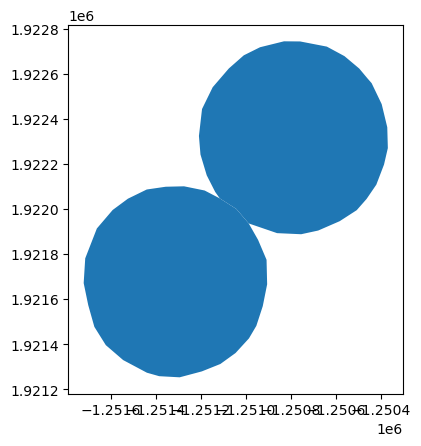

In [5]:
url = "https://services1.arcgis.com/99lidPhWCzftIe9K/arcgis/rest/services/WaterRelatedLandUse/FeatureServer/0/query?where=1%3D1&outFields=*&geometry=-110.75%2C39.438%2C-110.710%2C39.45&geometryType=esriGeometryEnvelope&inSR=4326&spatialRel=esriSpatialRelIntersects&outSR=5070&f=json"

well_fields = gpd.read_file(url)
well_fields = well_fields[well_fields['OBJECTID'].isin([53384,57425])]
well_fields.plot()

In [19]:
# Get the extent of the shapefile
total_bounds = well_fields.total_bounds

# Get minX, minY, maxX, maxY
minX, minY, maxX, maxY = total_bounds

# Create a fishnet
x, y = (minX, minY)
geom_array = []

# Polygon Size
square_size = 20
while y <= maxY:
    while x <= maxX:
        geom = shapely.geometry.Polygon([(x,y), (x, y+square_size), (x+square_size, y+square_size), (x+square_size, y), (x, y)])
        geom_array.append(geom)
        x += square_size
    x = minX
    y += square_size

fishnet = gpd.GeoDataFrame(geom_array, columns=['geometry']).set_crs('EPSG:5070')
#fishnet.to_file('fishnet_grid.shp')

In [6]:


# Create a geometry column
df['geometry'] = gpd.points_from_xy(df['X_FETCH_55'], df['Y_FETCH_55'])
df['geometry'].unique()
# Convert the DataFrame to a GeoDataFrame
#gdf = gpd.GeoDataFrame(df, geometry='geometry')

<GeometryArray>
[             <POINT EMPTY>, <POINT (-1251030 1921960)>,
 <POINT (-1250960 1921940)>, <POINT (-1251020 1921940)>,
 <POINT (-1251030 1921920)>, <POINT (-1251020 1921910)>,
 <POINT (-1251040 1921900)>, <POINT (-1251040 1921930)>,
 <POINT (-1251050 1921940)>, <POINT (-1250980 1921980)>,
 ...
 <POINT (-1251050 1922610)>, <POINT (-1251330 1922980)>,
 <POINT (-1251150 1922170)>, <POINT (-1251180 1922190)>,
 <POINT (-1251360 1922010)>, <POINT (-1251570 1922260)>,
 <POINT (-1251680 1922330)>, <POINT (-1252780 1923110)>,
 <POINT (-1251910 1922510)>, <POINT (-1251750 1922450)>]
Length: 4308, dtype: geometry

In [30]:
df

,datetime_start,TIMESTAMP_START,TIMESTAMP_END,CO2,CO2_SIGMA,H2O,H2O_SIGMA,FC,FC_SSITC_TEST,LE,...,X_FETCH_MAX,Y_FETCH_MAX,Date,X_FETCH_90,Y_FETCH_90,X_FETCH_55,Y_FETCH_55,X_FETCH_40,Y_FETCH_40,geometry
0,2023-06-14 11:00:00,202306141100,202306141130,-9999.0000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000,...,NaN,NaN,2023-06-14,NaN,NaN,NaN,NaN,NaN,NaN,POINT (NaN NaN)
1,2023-06-14 11:30:00,202306141130,202306141200,-9999.0000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000,...,NaN,NaN,2023-06-14,NaN,NaN,NaN,NaN,NaN,NaN,POINT (NaN NaN)
2,2023-06-14 12:00:00,202306141200,202306141230,404.8652,7.160377,11.003180,1.408956,-9999.000000,-9999.0,394.658600,...,-1251020.0,1921960.0,2023-06-14,-1251060.0,1921950.0,-1251030.0,1921960.0,-1251030.0,1921960.0,POINT (-1251030 1921960)
3,2023-06-14 12:30:00,202306141230,202306141300,403.2438,6.578680,10.929970,1.396008,-19.724970,-9999.0,277.552900,...,-1250970.0,1921940.0,2023-06-14,-1250930.0,1921920.0,-1250960.0,1921940.0,-1250970.0,1921940.0,POINT (-1250960 1921940)
4,2023-06-14 13:00:00,202306141300,202306141330,397.2703,7.669390,12.208020,1.357026,-29.465460,-9999.0,290.635000,...,-1251010.0,1921940.0,2023-06-14,-1251040.0,1921920.0,-1251020.0,1921940.0,-1251010.0,1921940.0,POINT (-1251020 1921940)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23143,2024-10-08 14:30:00,202410081430,202410081500,401.5762,0.373631,2.863288,0.053154,-0.284607,-9999.0,5.291050,...,-1250990.0,1921870.0,2024-10-08,-1250970.0,1921700.0,-1250980.0,1921830.0,-1250990.0,1921860.0,POINT (-1250980 1921830)
23144,2024-10-08 15:00:00,202410081500,202410081530,401.5929,0.473523,2.466282,0.107060,-0.755953,2.0,0.461339,...,-1251080.0,1921960.0,2024-10-08,-1251220.0,1921960.0,-1251110.0,1921960.0,-1251090.0,1921960.0,POINT (-1251110 1921960)
23145,2024-10-08 15:30:00,202410081530,202410081600,401.3630,0.335989,2.445982,0.044886,-0.116504,-9999.0,4.989396,...,-1251080.0,1921980.0,2024-10-08,-1251230.0,1922030.0,-1251120.0,1921990.0,-1251090.0,1921980.0,POINT (-1251120 1921990)
23146,2024-10-08 16:00:00,202410081600,202410081630,401.1919,0.380539,2.550954,0.069491,-0.942505,2.0,11.713800,...,-1251070.0,1921940.0,2024-10-08,-1251200.0,1921920.0,-1251100.0,1921940.0,-1251080.0,1921940.0,POINT (-1251100 1921940)
